In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors as colors
import matplotlib.patches as patches

Functions

In [69]:
def extract_expectation(x_sample, W_j, MU, SIGMA):
    """ estimate probability of the sample given each cluster (p(x|theta))"""
    x_sample = x_sample.reshape(1, -1)
    dim = x_sample.size
    weighted_p_x_ij = np.zeros( W_j.size )
    for cluster in range( W_j.size ):
        # extract distribution moments
        mu = MU[cluster].reshape(1, -1)
        sigma = SIGMA[cluster]
        deviation = x_sample-mu
        prob_x_ij = 1 / np.sqrt( (2*np.pi)**dim * np.linalg.det(sigma) ) * np.exp( -1 / 2 * deviation @ np.linalg.inv(sigma) @ deviation.transpose() )
        weighted_p_x_ij[cluster] = W_j[cluster] * prob_x_ij
    # compute expectation of sample X in each cluster
    w_i = weighted_p_x_ij / weighted_p_x_ij.sum()
    return w_i



def extract_maximization(X, W_ij):
    MU = np.zeros( (W_ij.shape[-1], X.shape[-1]) )
    SIGMA = [None] *  W_ij.shape[-1]
    W_j = np.zeros( W_ij.shape[-1] )
    for cluster in range( W_ij.shape[-1] ):
        # extract new MU
        MU[cluster, :] = ( W_ij[:, cluster].transpose() @ X / W_ij[:, cluster].sum() ).reshape(-1)
        # extract new SIGMA
        deviation = X - np.repeat(MU[cluster, :].reshape(1, -1), X.shape[0], axis=0)
        weighting = W_ij[:, cluster].transpose()
        normalization = ( W_ij[:, cluster] ).sum()
        temp = np.array( (W_ij.shape[-1], W_ij.shape[-1]) )
        for sample in range(weighting.size):
            sample_deviation = deviation[sample, :].reshape(-1, 1)
            temp = temp + weighting[sample] * ( sample_deviation @ sample_deviation.transpose() )
        SIGMA[cluster] = temp / normalization
        # extract new W_j
        W_j[cluster] = ( W_ij[:, cluster] ).mean()
    return W_j, MU, SIGMA


def GMM_init(dim, K = int(2)):
    w = []
    mu = []
    SIGMA = []
    for k in range(K):
        w.append(1/K)
        mu.append(np.random.randn(1,dim) )
        SIGMA.append( np.abs(np.eye(dim)) )
    W_j = np.vstack( w )
    MU = np.vstack( mu )
    return W_j, MU, SIGMA

def GMM(x, K = 2, max_iter = 10):
    # initialize
    K = int(K)
    W_j, MU, SIGMA = GMM_init(x.shape[-1], K)

    # run the algorithm
    W_ij = np.zeros( (x.shape[0], K) )

    iter = 0
    output = []
    while iter < max_iter:
        iter = iter + 1

        # assign to output
        Results = {'W_j': W_j, 'MU': MU, 'SIGMA': SIGMA, 'W_ij': W_ij}
        output.append( Results )
        
        # run expectation step
        for ind in range( x.shape[0] ):
            x_sample = x[ind, :]
            W_ij[ind, :] = extract_expectation(x_sample, W_j, MU, SIGMA)
        
        # run maximization step
        W_j, MU, SIGMA = extract_maximization(x, W_ij)       
    return output
    

def plot_data(x, labels, alpha=0.6):
    fig = plt.figure(figsize=(20,10))
    df = pd.DataFrame( np.hstack((x, labels)), columns=['x','y','labels'] )
    df.set_index('labels', inplace=True)
    palette = [plt.cm.tab10(cluster) for cluster in range( np.unique(labels).size )]
    _ = sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1], hue= df.index, palette=palette, alpha=alpha, s=5, edgecolor=None)
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    return ax

Create data

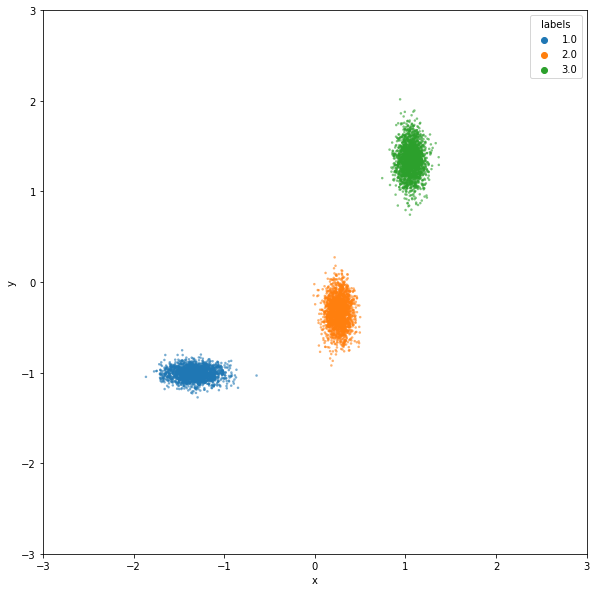

In [77]:
# create random data
N = 2000
x1 = np.random.normal(-1, 0.1, (N, 2)) @ np.array([[2,0],[0, 0.4]])
x2 = np.random.normal(0, 0.1, (N, 2))
x3 = np.random.normal(1, 0.1, (N, 2))
labels = np.repeat([1,2,3], N).reshape(-1, 1)
x = np.concatenate((x1, x2, x3), axis=0)

# whiten data
x = (x - x.mean(axis=0)) / x.std(axis=0)

# plot data
ax = plot_data(x, labels)

Run GMM

In [78]:
max_iter = 10
output = GMM(x, K = 3, max_iter = max_iter)

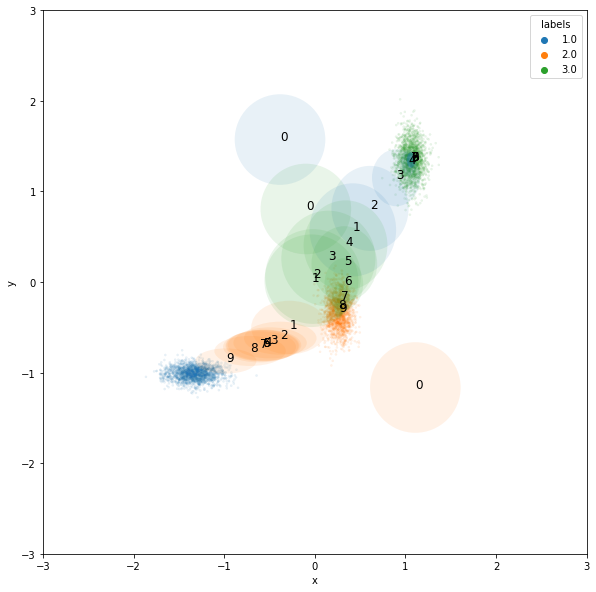

In [80]:
# Visualize the performance
ax = plot_data(x, labels, alpha=0.1)
for iter in range( len(output) ):
    for cluster in range( output[-1]['MU'].shape[0] ):
        center = [output[iter]['MU'][cluster, 0], output[iter]['MU'][cluster, 1]]
        sigma1 = np.sqrt( output[iter]['SIGMA'][cluster][0, 0] )
        sigma2 = np.sqrt( output[iter]['SIGMA'][cluster][1, 1] )
        ellipse = patches.Ellipse(center, sigma1, sigma2, alpha=0.1, facecolor=plt.cm.tab10(cluster))
        ax.add_patch(ellipse)
        ax.text(center[0], center[1], str(iter), fontdict={'fontsize':12})